# Project Name: Rental price prediction

Summary: In this project, we ask users to enter some variables(such as size,location etc) about their apartments and the model can predict/estimate the amount of cold rent for the given property.

The project is consist of following steps:
- Data wrangling and data cleaning (dealing wth Null values and outliers)
- Using the cleaned dataset to train the Linear Regression model and measure the accuracy of the model
- Optimizating the accuracy of the model by identyfing low impact features (variables) and removing them


In [78]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", message="DataFrame is highly fragmented.", category=pd.errors.PerformanceWarning)

In [79]:
# Read the webscraped Immoscout data, downloaded from Kaggle
file_path = 'https://raw.githubusercontent.com/okravtsova123/ironhack_study/main/MidTermProject/rent.csv'
try:
    df = pd.read_csv(file_path, encoding='utf-8', sep=';')
except UnicodeDecodeError:
    try:
        df = pd.read_csv(file_path, encoding='latin-1',  sep=';')
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='ISO-8859-1',  sep=';')

### Cleanng and preparing data

In [100]:
# Checking the df
df.head(3)

,level_0,index,baserent,balcony,haskitchen,cellar,livingspace,petsallowed,firingtypes,geo_krs,lift,norooms,floor,garden,energyefficiencyclass
0,8,87,1338.43,True,True,True,73.54,negotiable,district_heating,Berlin,True,2.0,0.0,False,B
1,10,118,1390.00,True,False,False,33.00,no,district_heating,M?nchen,True,1.0,3.0,False,C
2,13,156,1299.00,True,False,True,90.30,negotiable,district_heating,Hamburg,True,3.0,2.0,False,B


In [81]:
# Performing additional formatting for column names (lowercase, strip and replace spaces with underscores) - esier to work further
df.columns = [name.strip().replace(" ", "_").lower() for name in df.columns]
df.columns

Index(['regio1', 'servicecharge', 'heatingtype', 'telekomtvoffer',
       'telekomhybriduploadspeed', 'newlyconst', 'balcony', 'picturecount',
       'pricetrend', 'telekomuploadspeed', 'totalrent', 'yearconstructed',
       'scoutid', 'noparkspaces', 'firingtypes', 'haskitchen', 'geo_bln',
       'cellar', 'yearconstructedrange', 'baserent', 'housenumber',
       'livingspace', 'geo_krs', 'condition', 'interiorqual', 'petsallowed',
       'street', 'streetplain', 'lift', 'baserentrange', 'typeofflat',
       'geo_plz', 'norooms', 'thermalchar', 'floor', 'numberoffloors',
       'noroomsrange', 'garden', 'livingspacerange', 'energyefficiencyclass'],
      dtype='object')

In [83]:
# Checking null values
def null_check(df):
    print(f'Total null values per row: \n{df.isnull().sum(axis=1)}\n')
    print(f'Total null values per column: \n{df.isnull().sum()}\n')
    
null_check(df)

Total null values per row: 
0         3
1         8
2         4
3         8
4         8
         ..
268845    7
268846    7
268847    3
268848    4
268849    9
Length: 268850, dtype: int64

Total null values per column: 
regio1                           0
servicecharge                 6909
heatingtype                  44856
telekomtvoffer               32619
telekomhybriduploadspeed    223830
newlyconst                       0
balcony                          0
picturecount                     0
pricetrend                    1832
telekomuploadspeed           33358
totalrent                    40517
yearconstructed              57045
scoutid                          0
noparkspaces                175798
firingtypes                  56964
haskitchen                       0
geo_bln                          0
cellar                           0
yearconstructedrange         57045
baserent                         0
housenumber                  71018
livingspace                      0
geo_krs  

In [84]:
# Finding duplicates
def dup_check(df):
    print(f'Duplicates found: {df.duplicated().any()}\n')
    print(f'Number of duplicates: {df.duplicated().sum()}\n')
    
dup_check(df)

Duplicates found: False

Number of duplicates: 0



In [85]:
# Choosing only new buildings for prediction rental price because they are not controlled by government
df = df[(df['newlyconst']== True)]

In [86]:
# Counting number of unique locations
df["geo_krs"].nunique()

402

In [101]:
# Choosing the features for the model 
df = df.loc[:, ['baserent', 'balcony', 'haskitchen',
       'cellar','livingspace', 'petsallowed', 'firingtypes','geo_krs', 'lift', 'norooms', 'floor', 'garden', 'energyefficiencyclass']]
df.head(3)

,baserent,balcony,haskitchen,cellar,livingspace,petsallowed,firingtypes,geo_krs,lift,norooms,floor,garden,energyefficiencyclass
0,1338.43,True,True,True,73.54,negotiable,district_heating,Berlin,True,2.0,0.0,False,B
1,1390.00,True,False,False,33.00,no,district_heating,M?nchen,True,1.0,3.0,False,C
2,1299.00,True,False,True,90.30,negotiable,district_heating,Hamburg,True,3.0,2.0,False,B


In [88]:
df = df.reset_index()
df.head(3)

,index,baserent,balcony,haskitchen,cellar,livingspace,petsallowed,firingtypes,geo_krs,lift,norooms,floor,garden,energyefficiencyclass
0,2,965.00,True,False,True,83.80,NaN,NaN,Dresden,True,3.0,3.0,False,NaN
1,14,972.60,True,False,True,87.00,negotiable,gas,Dortmund,True,3.0,0.0,False,NaN
2,29,520.08,True,False,True,47.28,NaN,district_heating,Schwerin,True,2.0,NaN,False,NaN


In [89]:
null_check(df)

Total null values per row: 
0        3
1        1
2        3
3        1
4        1
        ..
21166    1
21167    3
21168    1
21169    1
21170    1
Length: 21171, dtype: int64

Total null values per column: 
index                        0
baserent                     0
balcony                      0
haskitchen                   0
cellar                       0
livingspace                  0
petsallowed               9357
firingtypes               5328
geo_krs                      0
lift                         0
norooms                      0
floor                     5238
garden                       0
energyefficiencyclass    11456
dtype: int64



In [90]:
df = df.dropna()

In [91]:
# Unifying heating types
def firingtypes_clean(ftype):
    
    if 'gas' in ftype:
        ftype='gas'
    elif 'electricity' in ftype:
        ftype='electricity'
    elif 'solar_heating' in ftype or 'wind_energy' in ftype or'hydro_energy' in ftype or 'bio_energy' in ftype or 'geothermal' in ftype or 'thermal_energy' in ftype or 'renewable_energy' in ftype or 'regenerative_energy' in ftype:
        ftype='renewable_energy_heating'
    elif "pellet_heating" in ftype or 'fossil_fuels' in ftype or 'wood_chips' in ftype:
        ftype='pellet_heating'
    elif 'district_heating' in ftype:
        ftype='district_heating'
    else:
        ftype=ftype
        
    return ftype

In [93]:
# Applying defined function for cleaning    
df['firingtypes'] = df['firingtypes'].apply(firingtypes_clean)

In [94]:
# Checking energy efficiency class
print(df["energyefficiencyclass"].groupby(df["energyefficiencyclass"]).count())

energyefficiencyclass
A                 1047
A_PLUS             866
B                 1172
C                  247
D                   49
E                    8
F                    5
NO_INFORMATION     573
Name: energyefficiencyclass, dtype: int64


In [95]:
# Droping rows with NO_INFORMATION
df = df[df["energyefficiencyclass"]!='NO_INFORMATION'].reset_index()

In [20]:
# Cleaning two unnecessary columns and choosing relevant ones
columns_needed = ['baserent', 'balcony', 'haskitchen',
       'cellar','livingspace', 'petsallowed', 'geo_krs', 'lift', 'norooms', 'floor', 'garden', 'energyefficiencyclass']
df = df.loc[: , columns_needed]

In [96]:
# Cleaning typos
def regio1_clean(region):
    if region == 'Baden_W?rttemberg':
        region = 'Baden-Württemberg'
    elif region == 'Th?ringen':
        region = 'Thüringia'
    else:
        region=region
        
    return region

In [22]:
# Cheking spelling mistakes in geo_krs
#REMOVE cities with less than 10 appartments, because they give too much influence in model
cities = df.groupby('geo_krs').size().reset_index(name='count')
cities_to_drop = cities[cities['count'] <= 20]
df = df[~df['geo_krs'].isin(cities_to_drop['geo_krs'])].reset_index(drop=True)
df['geo_krs'].groupby(df['geo_krs']).count()

geo_krs
Aachen                         26
Aachen_Kreis                   24
Berlin                        389
Bielefeld                      24
Bonn                           33
Braunschweig                   33
D?sseldorf                     53
Dortmund                       24
Dresden                       142
Frankfurt_am_Main             134
G?tersloh_Kreis                32
Gro?_Gerau_Kreis               21
Hamburg                        87
Hannover_Kreis                 22
Harburg_Kreis                  24
Heilbronn_Kreis                21
Koblenz                        22
Leipzig                       152
M?hldorf_am_Inn_Kreis          33
M?nchen                       140
M?nchengladbach                33
M?nster                        23
Magdeburg                      31
Main_Kinzig_Kreis              26
Mainz                          30
Mannheim                       51
N?rnberg                       25
Offenbach_Kreis                29
Ortenaukreis                   25
Potsda

In [98]:
# Counting pet-allowed groups
df['petsallowed'].groupby(df['petsallowed']).count()

petsallowed
negotiable    1974
no            1244
yes            176
Name: petsallowed, dtype: int64

In [24]:
# Checking outliers - identifying IQR
df['baserent'].describe()
IQR=df['baserent'].quantile(0.75)-df['baserent'].quantile(0.25)
base_min=df['baserent'].quantile(0.25)-1.5*IQR
base_max=df['baserent'].quantile(0.75)+3*IQR
print(base_min, base_max)

#countring how many flats are outliers
x_low=0
x_high=0
for price in df['baserent']:
    if price<base_min:
        x_low+=1
    elif price>base_max:
        x_high+=1

print(f'outliers too low:{x_low}\noutliers too high: {x_high}')

-60.0 3350.0
outliers too low:0
outliers too high: 17


In [25]:
# Dropping rows with outliers
df = df.loc[df['baserent']<base_max]

### Machine Learning 

In [26]:
# Splitting df into numericals and categoricals
categoricals = df.select_dtypes(include=[object, bool])
numericals = df.select_dtypes(include = 'number')

In [27]:
categoricals.head(3)

,balcony,haskitchen,cellar,petsallowed,geo_krs,lift,garden,energyefficiencyclass
0,True,True,True,negotiable,Berlin,True,False,B
1,True,False,False,no,M?nchen,True,False,C
2,True,False,True,negotiable,Hamburg,True,False,B


In [28]:
numericals.head(3)

,baserent,livingspace,norooms,floor
0,1338.43,73.54,2.0,0.0
1,1390.00,33.00,1.0,3.0
2,1299.00,90.30,3.0,2.0


In [29]:
ordinals = categoricals[["energyefficiencyclass", "balcony","haskitchen", "cellar", "lift", "garden", "petsallowed"]].reset_index()
nominals = categoricals.drop(columns=["energyefficiencyclass", "balcony","haskitchen", "cellar", "lift", "garden","petsallowed"]).reset_index()


In [30]:
nominals=nominals.drop('index', axis=1)
nominals

,geo_krs
0,Berlin
1,M?nchen
2,Hamburg
3,M?nchen
4,Dresden
...,...
1856,Dresden
1857,Leipzig
1858,Dresden
1859,Berlin


In [31]:
# Checking how we will encode the ordinals
ordinals["energyefficiencyclass"].groupby(df["energyefficiencyclass"]).count()

energyefficiencyclass
A         521
A_PLUS    355
B         765
C         173
D          29
E           1
Name: energyefficiencyclass, dtype: int64

In [32]:
from sklearn.preprocessing import OrdinalEncoder

In [33]:
# Encoding energy efficiency class for model creation
enc = OrdinalEncoder(categories=[["F", "E", "D", "C", "B","A", "A_PLUS"]])

ordinals["energyefficiencyclass"] = enc.fit_transform(ordinals[["energyefficiencyclass"]])

In [34]:
# Encoding haskitchen for model creation
ordinals["haskitchen"] = ordinals["haskitchen"].astype(object)
enc = OrdinalEncoder(categories=[[False, True]])
ordinals["haskitchen"] = enc.fit_transform(ordinals[["haskitchen"]])

In [35]:
# Encoding balcony for model creation
ordinals["balcony"] = ordinals["balcony"].astype(object)
enc = OrdinalEncoder(categories=[[False, True]])
ordinals["balcony"] = enc.fit_transform(ordinals[["balcony"]])

In [36]:
# Encoding cellar for model creation
ordinals["cellar"] = ordinals["cellar"].astype(object)
enc = OrdinalEncoder(categories=[[False, True]])
ordinals["cellar"] = enc.fit_transform(ordinals[["cellar"]])

In [37]:
# Encoding lift for model creation
ordinals["lift"] = ordinals["lift"].astype(object)
enc = OrdinalEncoder(categories=[[False, True]])
ordinals["lift"] = enc.fit_transform(ordinals[["lift"]])

In [38]:
# Encoding garden for model creation
ordinals["garden"] = ordinals["garden"].astype(object)
enc = OrdinalEncoder(categories=[[False, True]])
ordinals["garden"] = enc.fit_transform(ordinals[["garden"]])

In [39]:
# Encoding petsallowed for model creation
enc = OrdinalEncoder(categories=[['no', 'negotiable', 'yes']])
ordinals["petsallowed"] = enc.fit_transform(ordinals[["petsallowed"]])

In [40]:
# Making dummies from nominals
nominals = pd.get_dummies(nominals, dtype=int)

In [41]:
# Concating ordinals and nominals
categorical = pd.concat([ordinals,nominals], axis=1).reset_index()

In [42]:
categorical=categorical.drop(['level_0', 'index'], axis=1)

In [43]:
categorical=categorical.reset_index()


In [44]:
numericals=numericals.reset_index()


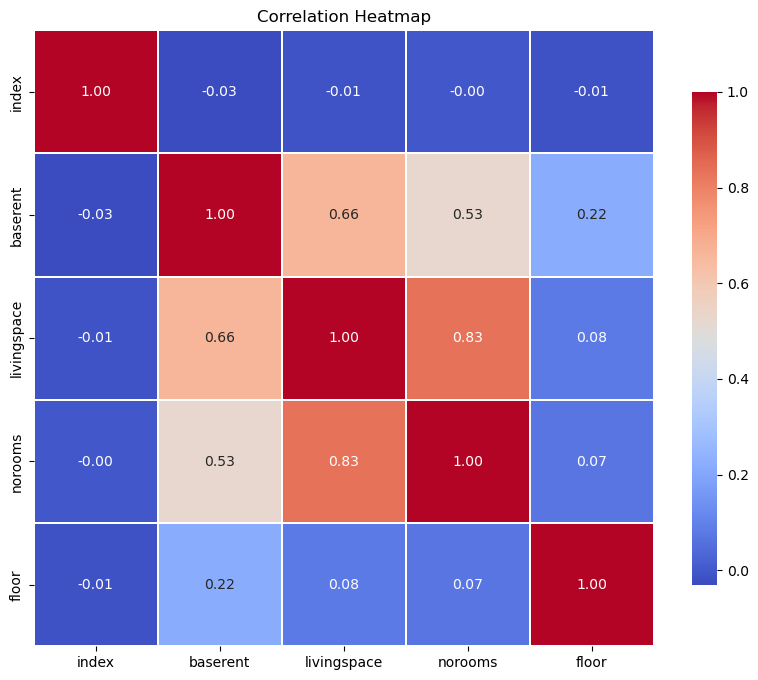

In [45]:
import matplotlib.pyplot as plt
corr_matrix = numericals.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.05, cbar_kws={'shrink': .8})
plt.title('Correlation Heatmap')
plt.show()

In [47]:
# Concating categoricals and numericals
final_df = pd.concat([numericals,categorical], axis=1).drop('index', axis=1)
final_df.head(3)

,baserent,livingspace,norooms,floor,energyefficiencyclass,balcony,haskitchen,cellar,lift,garden,...,geo_krs_N?rnberg,geo_krs_Offenbach_Kreis,geo_krs_Ortenaukreis,geo_krs_Potsdam_Mittelmark_Kreis,geo_krs_Rhein_Erft_Kreis,geo_krs_Rhein_Sieg_Kreis,geo_krs_Rheinisch_Bergischer_Kreis,geo_krs_Stade_Kreis,geo_krs_Stormarn_Kreis,geo_krs_Westerwaldkreis
0,1338.43,73.54,2.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1390.00,33.00,1.0,3.0,3.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1299.00,90.30,3.0,2.0,4.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Model creation

##### X-y split (y is the target variable, in this case, "cold rent")

In [48]:
#X-y split
X=final_df.drop('baserent', axis=1)
y=final_df[['baserent']]


In [49]:
X.head()

,livingspace,norooms,floor,energyefficiencyclass,balcony,haskitchen,cellar,lift,garden,petsallowed,...,geo_krs_N?rnberg,geo_krs_Offenbach_Kreis,geo_krs_Ortenaukreis,geo_krs_Potsdam_Mittelmark_Kreis,geo_krs_Rhein_Erft_Kreis,geo_krs_Rhein_Sieg_Kreis,geo_krs_Rheinisch_Bergischer_Kreis,geo_krs_Stade_Kreis,geo_krs_Stormarn_Kreis,geo_krs_Westerwaldkreis
0,73.54,2.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,33.00,1.0,3.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,90.30,3.0,2.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,91.00,1.5,2.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,116.28,3.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
y.head()

,baserent
0,1338.43
1,1390.00
2,1299.00
3,1680.00
4,1337.22


### train_test_split

In [51]:
#train_test split


In [52]:
from sklearn.model_selection import train_test_split


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)


In [54]:
columns_order = X_train.columns
columns_order

Index(['livingspace', 'norooms', 'floor', 'energyefficiencyclass', 'balcony',
       'haskitchen', 'cellar', 'lift', 'garden', 'petsallowed',
       'geo_krs_Aachen', 'geo_krs_Aachen_Kreis', 'geo_krs_Berlin',
       'geo_krs_Bielefeld', 'geo_krs_Bonn', 'geo_krs_Braunschweig',
       'geo_krs_D?sseldorf', 'geo_krs_Dortmund', 'geo_krs_Dresden',
       'geo_krs_Frankfurt_am_Main', 'geo_krs_G?tersloh_Kreis',
       'geo_krs_Gro?_Gerau_Kreis', 'geo_krs_Hamburg', 'geo_krs_Hannover_Kreis',
       'geo_krs_Harburg_Kreis', 'geo_krs_Heilbronn_Kreis', 'geo_krs_Koblenz',
       'geo_krs_Leipzig', 'geo_krs_M?hldorf_am_Inn_Kreis', 'geo_krs_M?nchen',
       'geo_krs_M?nchengladbach', 'geo_krs_M?nster', 'geo_krs_Magdeburg',
       'geo_krs_Main_Kinzig_Kreis', 'geo_krs_Mainz', 'geo_krs_Mannheim',
       'geo_krs_N?rnberg', 'geo_krs_Offenbach_Kreis', 'geo_krs_Ortenaukreis',
       'geo_krs_Potsdam_Mittelmark_Kreis', 'geo_krs_Rhein_Erft_Kreis',
       'geo_krs_Rhein_Sieg_Kreis', 'geo_krs_Rheinisch_Bergis

array([[<Axes: title={'center': 'baserent'}>]], dtype=object)

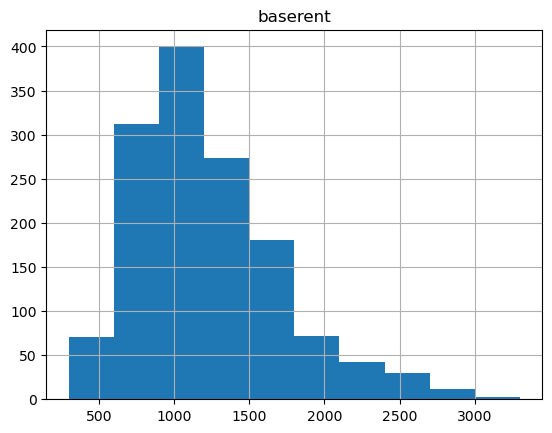

In [56]:
y_train.hist()

### using powertransform for X and Y


In [57]:
from sklearn.preprocessing import PowerTransformer


In [58]:
# Fitting power transformer to use in train and test sets
pt=PowerTransformer()
pt.fit(X_train)

PowerTransformer()

In [59]:
# Transforming train and test sets
X_train=pt.transform(X_train)
X_test=pt.transform(X_test)

## CREATING LINEAR REGRESSION MODEL, TRAIN & TEST IT

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

In [61]:
lr=LinearRegression()

In [62]:
#creating model
model=lr.fit(X_train,y_train)
lr.intercept_

array([1227.13563526])

<Axes: xlabel='coeff', ylabel='name'>

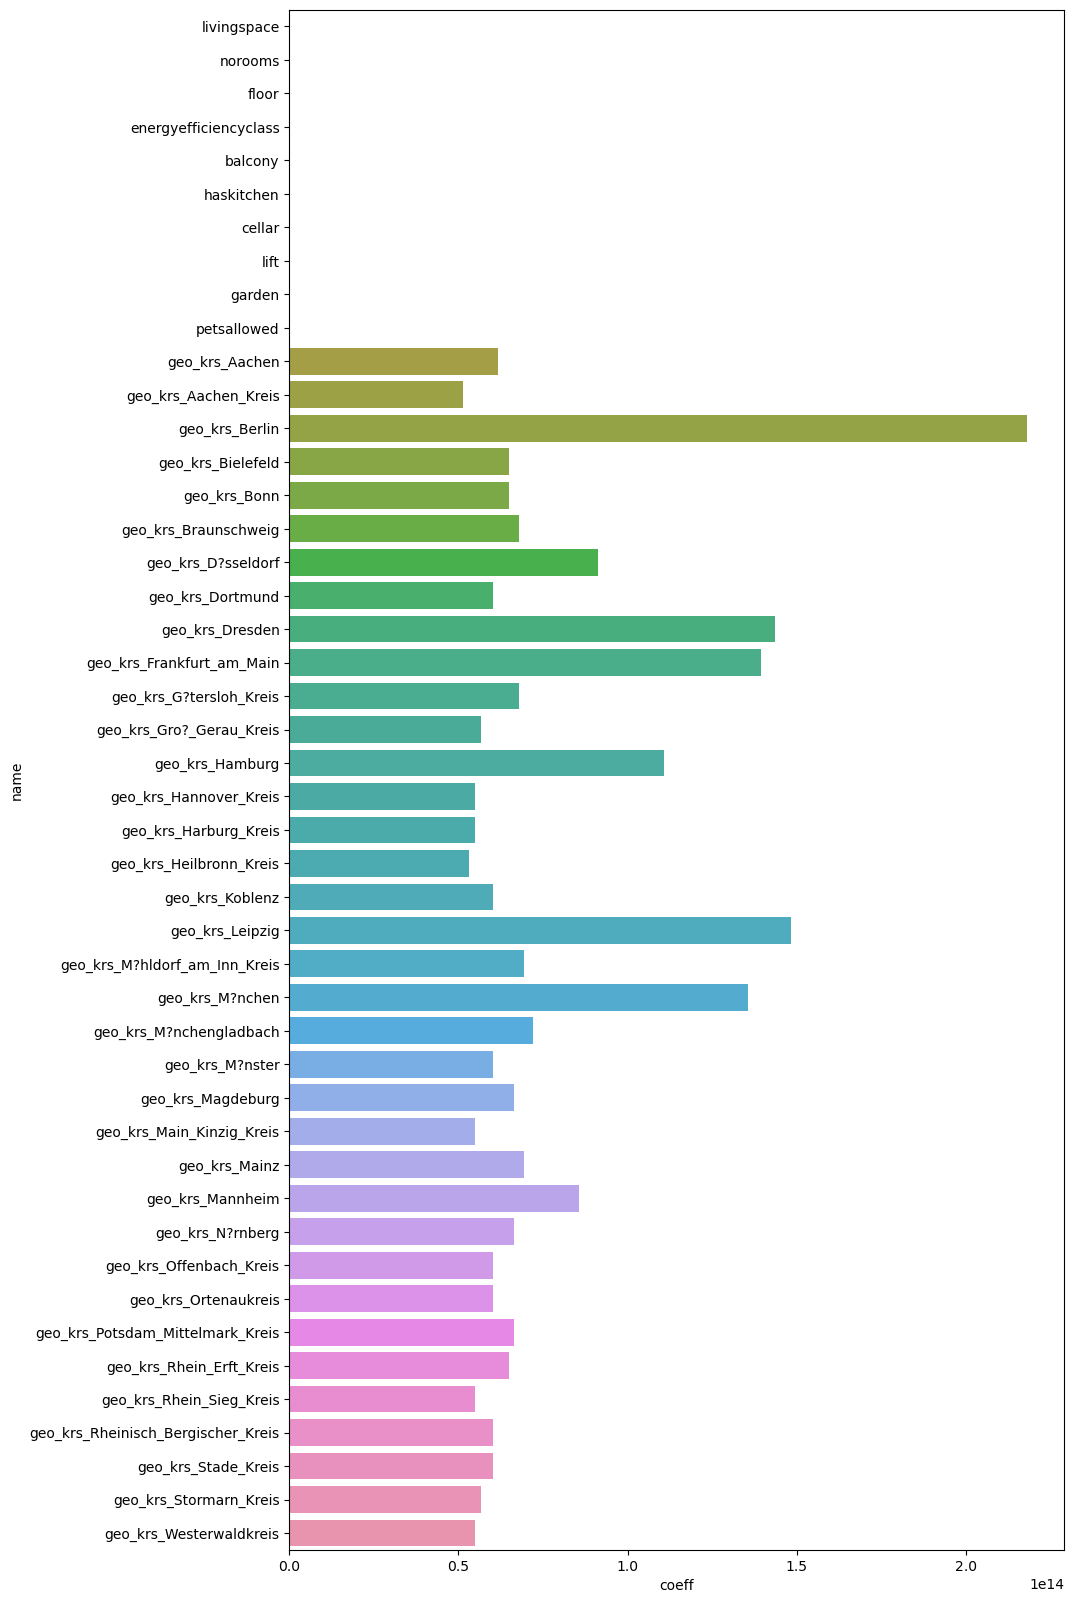

In [63]:
#visualizing
feature_names1=list(X.columns)
coefficients1 = model.coef_
coefficients1=[i for i in coefficients1[0]]

fi_dict1 = {"name":feature_names1,"coeff":coefficients1}
fi_df1 = pd.DataFrame(fi_dict1)
fi_df1
plt.figure(figsize=(10, 20))
sns.barplot(y = fi_df1["name"],x =fi_df1["coeff"])

In [64]:
#test model
y_pred=pd.DataFrame(lr.predict(X_test))

In [65]:
#calculating mean errors
MSE_full=mse(y_pred,y_test)
RMSE_full=mse(y_pred,y_test, squared=False)
print(f"mse_full:{MSE_full}\nRMSE:{RMSE_full}")

mse_full:51900.9351396479
RMSE:227.81776739237856


In [66]:
#calculating R2 for predictions
r2_score(y_test,y_pred)

0.8022236805426369

In [67]:
#calculating r2_score for train set
y_train_pred=pd.DataFrame(lr.predict(X_train))
r2_score(y_train,y_train_pred)

0.7905476553260256

In [68]:
y_train_pred=pd.DataFrame(y_train_pred)
y_train_pred.head()

,0
0,1824.795792
1,706.225479
2,562.170792
3,976.108292
4,1176.358292


In [69]:
y_train.head()

,baserent
100,1715.0
274,770.0
1632,675.0
353,950.0
101,1100.0


In [99]:
# Creating user interface - Getting input variables from users
def input_data():
    column_names = ['livingspace', 'norooms', 'floor', 'energyefficiencyclass', 'balcony', 'haskitchen', 'cellar', 'lift', 'garden','petsallowed', 'geo_krs']
    df_input=pd.DataFrame(columns=column_names)
    row_index = 1
    for i in column_names:
        if i=='livingspace':
            x=input('What is the size of the appartment? Input a number of sqr m: ')
            x=int(x)
            df_input.loc[row_index, i] = x
        elif i=='norooms':
            x=input('How many rooms are in the appartment? Input a number of rooms: ')
            x=int(x)
            df_input.loc[row_index, i] = x
        elif i=='floor':
            x=input('What floor is it at? Input a number: ')
            x=int(x)
            df_input.loc[row_index, i] = x
        elif i=='energyefficiencyclass':
            x=input('What energy efficiency class is it? Input a letter: ')
            x=x.upper()
            if x=='A+':
                x='A_PLUS'
            df_input.loc[row_index, i] = x
        elif i=='balcony':
            x=input('Does it have a balcony? Say yes or no: ')
            if x=='yes':
                x=True
            elif x=='no':
                x=False
            df_input.loc[row_index, i] = x
        elif i=='haskitchen':
            x=input('Does it have kitchen? Say yes or no: ')
            if x=='yes':
                x=True
            elif x=='no':
                x=False
            df_input.loc[row_index, i] = x
        elif i=='cellar':
            x=input('Does it have cellar? Say yes or no: ')
            if x=='yes':
                x=True
            elif x=='no':
                x=False
            df_input.loc[row_index, i] = x
        elif i=='lift':
            x=input('Does it have lift? Say yes or no: ')
            if x=='yes':
                x=True
            elif x=='no':
                x=False
            df_input.loc[row_index, i] = x
        elif i=='garden':
            x=input('Does it have garden? Say yes or no: ')
            if x=='yes':
                x=True
            elif x=='no':
                x=False
            df_input.loc[row_index, i] = x 
        elif i=='petsallowed':
            x=input('Are the pets allowed in this appartment? Input yes, no or negotiable: ')
            df_input.loc[row_index, i] = x 
        elif i=='geo_krs':
            x=input('What is the city? Please choose one of those in the list: ')
            df_input.loc[row_index, i] = x
    return df_input

In [72]:
#FUNCTION FOR PREDICTION
def predict(input_df):
    #splitting df into numericals and categoricals
    input_df['livingspace'] = input_df['livingspace'].astype(float)
    input_df['norooms'] = input_df['norooms'].astype(float)
    input_df['floor'] = input_df['floor'].astype(float)

    categoricals_input = input_df.select_dtypes(include=[object, bool])
    numericals_input = input_df.select_dtypes(include = 'number').reset_index()

    #splitting ordinals and categoricals
    ordinals_input = categoricals_input[["energyefficiencyclass", "balcony","haskitchen", "cellar", "lift", "garden", "petsallowed"]].reset_index()
    nominals_input = categoricals_input.drop(columns=["energyefficiencyclass", "balcony","haskitchen", "cellar", "lift", "garden","petsallowed"]).reset_index()

    #encoding energy efficiency class 
    enc_input = OrdinalEncoder(categories=[["F", "E", "D", "C", "B","A", "A_PLUS"]])
    ordinals_input["energyefficiencyclass"] = enc_input.fit_transform(ordinals_input[["energyefficiencyclass"]])
    
    #encoding haskitchen
    
    ordinals_input["haskitchen"] = ordinals_input["haskitchen"].astype(object)
    enc_input = OrdinalEncoder(categories=[[False, True]])
    ordinals_input["haskitchen"] = enc_input.fit_transform(ordinals_input[["haskitchen"]])
    
    #encoding balcony

    ordinals_input["balcony"] = ordinals_input["balcony"].astype(object)
    enc = OrdinalEncoder(categories=[[False, True]])
    ordinals_input["balcony"] = enc_input.fit_transform(ordinals_input[["balcony"]])

    #encoding cellar
    ordinals_input["cellar"] = ordinals_input["cellar"].astype(object)
    enc = OrdinalEncoder(categories=[[False, True]])
    ordinals_input["cellar"] = enc_input.fit_transform(ordinals_input[["cellar"]])
    
    #encoding lift
    
    ordinals_input["lift"] = ordinals_input["lift"].astype(object)
    enc = OrdinalEncoder(categories=[[False, True]])
    ordinals_input["lift"] = enc_input.fit_transform(ordinals_input[["lift"]])

    #encoding garden

    ordinals_input["garden"] = ordinals_input["garden"].astype(object)
    enc_input = OrdinalEncoder(categories=[[False, True]])
    ordinals_input["garden"] = enc_input.fit_transform(ordinals_input[["garden"]])

    #encoding petsallowed

    enc_input = OrdinalEncoder(categories=[['no', 'negotiable', 'yes']])
    ordinals_input["petsallowed"] = enc_input.fit_transform(ordinals_input[["petsallowed"]])

    #making dunnies from nominals
    nominals_input = pd.get_dummies(nominals_input, dtype=int)
    list_columns=final_df.columns.to_list()
    city_remove='geo_krs_'+input_df.loc[1, 'geo_krs']
    values_to_remove=['baserent','livingspace', 'norooms', 'floor', 'energyefficiencyclass', 'balcony', 'haskitchen', 'cellar', 'lift', 'garden','petsallowed', city_remove]
    for value in values_to_remove:
        if value in list_columns:
            list_columns.remove(value)
    for col_name in list_columns:
        nominals_input[col_name] = 0
        
        #concating categoricals and numericals
    X_input = pd.concat([numericals_input,ordinals_input,nominals_input], axis=1).drop('index', axis=1)
    X_input

    # Reorder the columns in X_input to match the order in X_train
    X_input = X_input.reindex(columns=columns_order)
    #pt1=PowerTransformer()
    #pt1.fit(X_train)
    X_input_transformed=pt.transform(X_input)
    y_pred_input=lr.predict(X_input_transformed)   
    #pt1.fit(y_train)
    #y_pred_input=np.round(pt1.inverse_transform(y_pred_input))

    print(f'The monthly base rent will be: {y_pred_input} EUR')


In [73]:
input_df=input_data()
predict(input_df)

What is the size of the appartment? Input a number of sqr m: 75
How many rooms are in the appartment? Input a number of rooms: 3
What floor is it at? Input a number: 8
What energy efficiency class is it? Input a letter: B
Does it have a balcony? Say yes or no: no
Does it have kitchen? Say yes or no: yes
Does it have cellar? Say yes or no: yes
Does it have lift? Say yes or no: yes
Does it have garden? Say yes or no: no
Are the pets allowed in this appartment? Input yes, no or negotiable: yes
What is the city? Please choose one of those in the list: Berlin
The monthly base rent will be: [[1500.51844776]] EUR
